In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load an official detection model

# Track with the model
# results = model.track(source="https://youtu.be/Zgi9g1ksQHc", show=True) 
results = model.track(source="traffic.mp4", show=True, tracker="bytetrack.yaml") 

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.5.4) /tmp/pip-req-build-4x5kub8r/opencv/modules/highgui/src/window.cpp:1274: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/513) /home/frozenwolf/Deskto

In [2]:
import gc

del model
gc.collect()

2967

In [3]:
import matplotlib.pyplot as plt
import cv2 
from tqdm.auto import tqdm
all_imgs = []

for result in tqdm(results):
    if result.boxes.id is None:
        image = result.orig_img
        all_imgs.append(image)
        continue
    boxes = result.boxes.xyxy.to('cpu').numpy().astype(int)
    confidences = result.boxes.conf.to('cpu').numpy().astype(float) 
    labels = result.boxes.cls.to('cpu').numpy().astype(int)
    id = result.boxes.id.to('cpu').numpy().astype(int)
    image = result.orig_img

    

    for ids, box, conf, label in zip(id, boxes, confidences, labels):
        # Crop vehicle
        # print(ids, conf, label)
        x_min, y_min, x_max, y_max = box
        image_crop = image[y_min:y_max, x_min:x_max]

        if label not in [2, 4, 5, 7]:
            continue
        image = cv2.rectangle(image, ( x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3)
        image = cv2.putText(image, f'CLASS: {label} ID: {ids}', ( x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 5)

    all_imgs.append(image)
        # plt.imshow(image)
        # plt.show()



  0%|          | 0/513 [00:00<?, ?it/s]

In [4]:
# result 2: 'car', 3: 'motorcycle', 5: 'bus' 7: 'truck'

In [5]:
vidcapture = cv2.VideoCapture('traffic.mp4')
fps = int(vidcapture.get(cv2.CAP_PROP_FPS))
totalNoFrames = vidcapture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = int(totalNoFrames // fps)

In [6]:
len(all_imgs), duration, fps

(513, 20, 25)

In [7]:

# all_imgs = np.asarray(all_imgs)
all_imgs[0].shape

(1080, 1920, 3)

In [8]:
import numpy as np
import cv2
# size = (200, 200)
# duration = total_frames//30
size = tuple(image.shape[:-1])
# fps = 30

out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for frame in all_imgs:
    out.write(frame)

out.release()

In [9]:
from Utilities.io import DataLoader
from Utilities.painter import Visualizer
from Models.RRDBNet import RRDBNet# we use RRDB in this demo
import glob

# pretrained rrdb network can be found in the Pretrained folder
MODEL_PATH = 'Pretrained/rrdb'
model = RRDBNet(blockNum=10)
model.load_weights(MODEL_PATH)

In [10]:
import tensorflow as tf
import numpy as np

def upscale(x):
    x = tf.convert_to_tensor(np.asarray([x/255.0]), dtype=tf.float32)
    print(x.shape)
    return model.predict(x)

# upscale(image_crop)

(1, 108, 213, 3)
1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


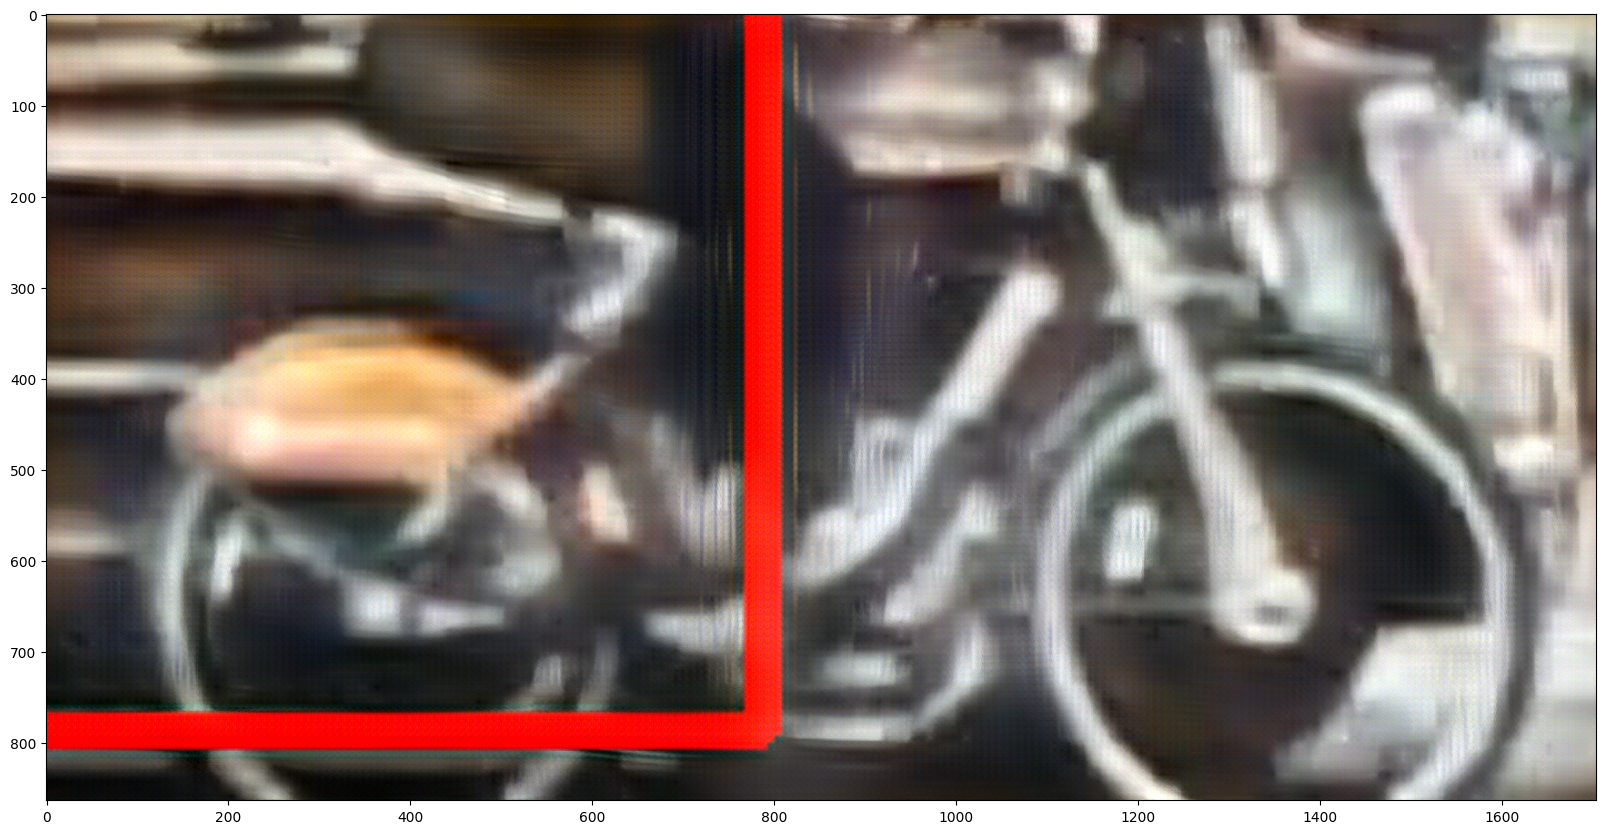

In [11]:
plt.imshow(upscale(image_crop)[0])

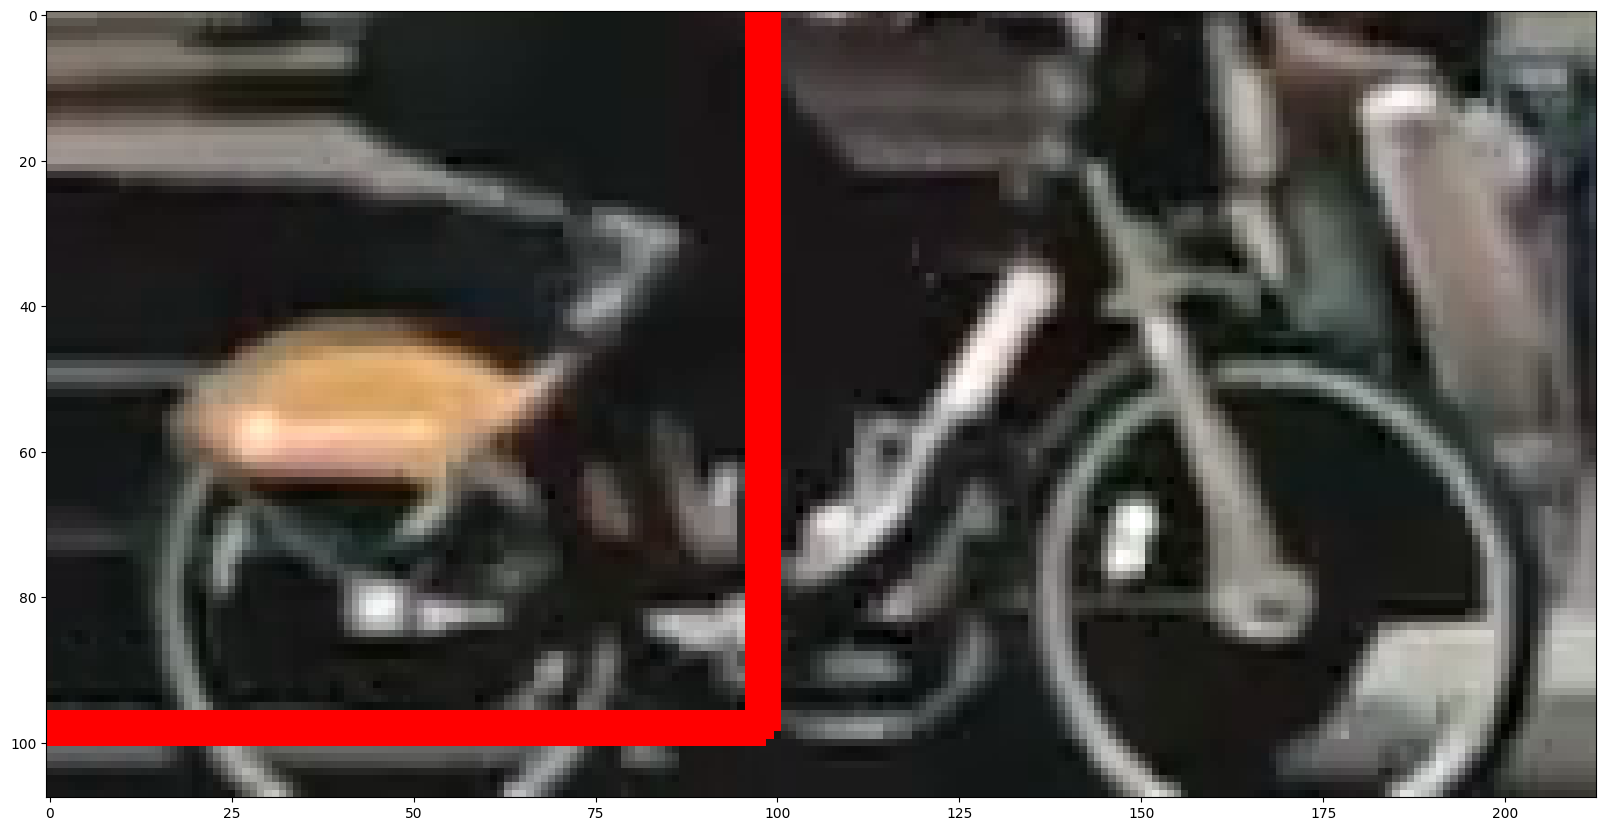

In [12]:
plt.imshow(image_crop)

In [13]:
# DATA_PATH = 'sample'
# loader = DataLoader()
# data = loader.load(glob.glob(DATA_PATH + '/*.jpg'), batchSize=1)